In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 张量--数据载体

In [3]:
#一些常用的赋值和操作
#最常用：float32
tf.zeros([3, 4], tf.int32)

tf.zeros_like(x)
tf.ones([2, 3], tf.float32)
tf.ones_like(x)

#常数
t = tf.constant([1, 2, 3, 4], tf.float32)
tf.constant(-1, shape=[2, 3])#-1填充的[2, 3]矩阵

t = tf.linspace(10., 12., 3, name='lsp') #[10, 11, 12], 3表示3个，包括12

#tf.range(start, limit, delta)#同样没有最后一个

In [17]:
norm = tf.random_normal([2, 3], mean=-1, stddev=4)

c = tf.constant([
    [1., 2],
    [3, 4],
    [5, 6]
], tf.float32)
#洗牌
shuff = tf.random_shuffle(c)

sess = tf.Session()
print(sess.run(norm))
print(sess.run(shuff))

[[-1.63572717 -2.22727728 -0.78743017]
 [ 1.86381507 -2.45669842 -7.04239273]]
[[ 1.  2.]
 [ 5.  6.]
 [ 3.  4.]]


In [2]:
a = tf.constant([1., 2, 3, 4], name='a', dtype=tf.float32)
with tf.Session() as sess:
#     print(a.set_shape([2, 2]))#会报错
    print(a.eval())

[ 1.  2.  3.  4.]


[静态维数与动态维数](https://blog.csdn.net/dcrmg/article/details/79766538)
- 在图构建过程中定义的张量拥有的维度是静态维度，这个维度可以被定义为不确定的，例如定义一个tensor的维度是[None,10]，表示这个tensor的第一个维度是不确定的，可以是任意的，None 表示具体维度值要在图运行过程中确定。


In [3]:
b = tf.constant([1., 2, 3, 4], name='b', dtype=tf.float32)
c = tf.add(a, b)
#a的后置操作
print('consumer:', a.consumers)
#c的前置操作
print('op:', c.op)
sess.close()

consumer: <bound method Tensor.consumers of <tf.Tensor 'a:0' shape=(4,) dtype=float32>>
op: name: "Add"
op: "Add"
input: "a"
input: "b"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}



In [4]:
#图对象的节点
print([node.name for node in c.graph.as_graph_def().node])

['a', 'b', 'Add']


### 稀疏张量
[文档](https://blog.csdn.net/coderpai/article/details/79006157)

In [5]:
sp = tf.SparseTensor(indices=[[0, 2], [1, 3]], values=np.array([2, 3], dtype=np.float32), dense_shape=[2, 3])

with tf.Session() as sess:
    print(sp.eval())
    #索引
    print(sp.indices)
    print(sp.indices.eval())
    #图
    print(sp.graph)
#     print(ind.eval())

SparseTensorValue(indices=array([[0, 2],
       [1, 3]], dtype=int64), values=array([ 2.,  3.], dtype=float32), dense_shape=array([2, 3], dtype=int64))
Tensor("SparseTensor/indices:0", shape=(2, 2), dtype=int64)
[[0 2]
 [1 3]]
['a', 'b', 'Add', 'b_1', 'Add_1', 'SparseTensor/indices', 'SparseTensor/values', 'SparseTensor/dense_shape']


#### 稀疏到密集转化

In [ ]:
de = tf.sparse_to_dense(sparse_indices = [[1,2],[2,1]], output_shape = [3,3], 
    sparse_values = [2,3], default_value = 1)

![](imgs/1.png)

In [ ]:
de = tf.sparse_tensor_to_dense(sp, default_value=1)

![](imgs/2.png)

#### 转化为密集布尔张量
![](imgs/3.png)
![](imgs/4.png)

In [ ]:
b = tf.sparse_to_indicator(sp, 10)

关于稀疏张量的更多操作参照书和文档

## 操作--模型载体

- 计算节点
    - operation类(P47):
    - 计算节点的属性
    - 数据基础操作
    - 流图中的变量
    - add的调用过程：
        - 初始化时global_variavle_initializer()执行的过程
        - 变量操作
        - read将张量转化为标量的调用栈
- 存储节点
    - Variable类
    - 变量初始值
    - 更新操作
    - 读取操作
        - read对应了tensorboard的identity（内部调用）
    - 变量操作：有状态操作，用于存储变量值，需要给定shape和size
        - 初始化方法：利用初始值or模型恢复，均为Variable类的私有方法
    
- 数据节点 placeholder
- 用例笔记：
```python
#没有显示指定数据形状，可以使用set_shape()改变静态维数
x = tf.sparse_placeholder(tf.float32)
```

In [2]:
#Create a variable
w = tf.Variable([
    [0.5, 1.]
])
x = tf.Variable([
    [2.],
    [1.],
])
t = tf.linspace(10., 12., 4, name='lsp')
#操作
y = tf.matmul(w, x)
print('w:', w)
print('x:', x)
#框架搭建完成，但是没有具体的值--并没有计算
print('y:', y)

w: <tf.Variable 'Variable:0' shape=(1, 2) dtype=float32_ref>
x: <tf.Variable 'Variable_1:0' shape=(2, 1) dtype=float32_ref>
y: Tensor("MatMul:0", shape=(1, 1), dtype=float32)


### Session,会话
- 会话，提供求解的环境，发放计算任务的客户端
- Tensor.eval()和Operation.run()的调用栈，都是Session.run()


#### 以下方式也可以得到张量的值
- Tensor.eval(self, feed_dict, session)
- Operation.run(self, feed_dict, session)这两个方法需要传入session，但如果使用：
```python
    with tf.Session() as sess:
        print(a.eval())
        pass
```
        则不需要，这种方法会自己将sess注册为默认sess


In [13]:
#对变量初始化
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    print(t, t.eval())

Tensor("lsp_2:0", shape=(4,), dtype=float32) [ 10.          10.66666698  11.33333302  12.        ]


#### 交互会话 

In [2]:
a = tf.constant(5.)
b = tf.constant(2.)
sess = tf.InteractiveSession()

In [4]:
print(a.eval())
c = a + b
print(c.eval())#类似shell编程的会话

5.0
7.0


## 优化器
- 常见优化器（P65）
- 优化器的组成：
    - 父类：Optimter类，包含了：
        - compute_gradients()：计算梯度
        - apply_gradients()：应用梯度
        - minimize()
    - 各个优化器各自实现：利用稠密，稀疏梯度值更新模型参数的具体实现
        - _apply_dense()
        - _apply_sparse()

#### minimize()的实现(P66)：
#### 重要：自己定义一些优化过程
```python
def minimize(self,):
    #计算梯度， 得到梯度值与模型参数列表 <梯度，参数>
    grads_and_vars = self.compute_gradients()
    #筛选：非零梯度值对应的模型参数列表
    vars_with_grad = [v for v, g in grads_and_vars if g is not None]
    #如果没有非零梯度值，则出错
    if not vars_with_grad:
        raise ValueError()
    #更新，返回模型参数值
    return self.apply_gradients()
```
    以上为minimize的大致结构
    minimize的参数(P67)，主要参数：gate_gradients,计算和运用梯度的顺序问题，关乎效率问题

#### 模板代码
```python
import tensorflow as tf

#模型
X = tf.placeholder(...)
Y_ = tf.placeholder(...)
w = tf.get_variable(...)
b = tf.get_variable(...)
#损失
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(...))
#优化方式
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
global_step  = tf.Variable(0, name='global_step', trainable=False)#注意这里trainable=False
train_op = optimizer.minimize(loss, global_step=global_step)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(max_train_steps):
        sess.run(train_op, feed_dict={...})
        #日志
        if step%log_step == 0:
            l, weigth, bias = sess.run([loss, w, b])
            print(...)
```

#### 其实通过minimize的实现方式我们可以自己定义优化过程
- 计算梯度
- 处理梯度
- 应用梯度

##### 计算梯度 compute_gradients() 的实现，具体参考P69
```python
def compute_gradients(...):
    #数据处理与判断
    ...#(包括获取var_list)
    #创建计算梯度的操作
    grads= gradients.gradients(...)
    #这种策略下，为所有计算梯度添加控制依赖边，保证任意梯度在使用前所有梯度都计算完毕
    if gate_gradients == Optimizer.GATE_GRAPH:
        grads = control_flow_ops.tuple(grads)
    #梯度模型参数表
    grads_and_vars = list(zip(grads, var_list))
    self._assert_valid_dtype([v for g, v in grads_and_vars if g is not None])
    return grads_and_vars
```

##### 梯度处理：
- tf内置的一些梯度处理方法(P70)
- 各种优化器的主要区别是在apply_gradients()中，我们的处理在这个之前
- 例子
```python
...#创建模型
optimizer = tf.train.AdamOptimizer(learning_rate=0.01, beta1=0.5)
grads_and_vars = optimizer.compute_gradients(loss, ...)
for i, (g, v)  in enumerate(grads_and_vars):
    if g is not None:
        #剪裁
        grads_and_vars[i] = (tf.clip_by_norm(g, 5), v)
train_op = optimzer.apply_gradients(grads_and_vars)
...
```
    
    这里将minimize的计算分开，可以自己优化函数，添加需要的处理，注意要参照好minimize的实现，minimize中的一些其他参数设定

##### 应用梯度
```python
def apply_gradients(self, ...):
    grads_and_vars = tuple(grads_and_vars)
    #省略错误检查
    converted_grads_and_vars = []
    for g, v in grads_and_vars:
        
        #省略错误检查
        p = _get_processor(v)#注意这里的p,获取更新的‘程序’
        converted_grads_and_vars.append((g, v, p))
        #转化到元祖类型，支持列表推演计算
    converted_grads_and_vars = tuple(converted_grads_and_vars)
    var_list = [v for g, v in grads_and_vars if g is not None]
    #省略var_list非空判断
    with ops.control_dependencies(None):
        self._create_slots(var_list)
    
    update_ops = []#更新操作汇总表
    self._prepare()
    for grad, var, processor in converted_grads_and_vars:
        if grad is None:
            continue
        #更新操作，使用之前的p，传入self，在更新时会使用各个optimizer的 apply_...() 方法
        update_ops.append(processor.update_ops(self, grad))
    #if global_step is None 如果有定义全局的迭代记录，这里有别的操作
    apply_updates = self._finish(update_ops, name)#控制依赖，确保updates_op操作执行完成
    
    #省略对train_op的操作

    return apply_updates
```

#### 上面这部分是对修改优化过程的总结，下面为线性回归实例

Start training:
Step:0, loss==11.4295, W==-0.3626, b==0.0822
Step:50, loss==0.0978, W==0.3336, b==0.2175
Step:100, loss==0.0955, W==0.3288, b==0.2518
Step:150, loss==0.0933, W==0.3242, b==0.2840
Step:200, loss==0.0915, W==0.3200, b==0.3144
Step:250, loss==0.0898, W==0.3159, b==0.3429
Step:300, loss==0.0883, W==0.3122, b==0.3698
Step:350, loss==0.0870, W==0.3086, b==0.3950
Step:400, loss==0.0859, W==0.3052, b==0.4188
Step:450, loss==0.0848, W==0.3021, b==0.4412
Step:500, loss==0.0839, W==0.2991, b==0.4623
Step:550, loss==0.0831, W==0.2963, b==0.4821
Step:600, loss==0.0824, W==0.2937, b==0.5008
Step:650, loss==0.0818, W==0.2912, b==0.5183
Step:700, loss==0.0812, W==0.2889, b==0.5349
Step:750, loss==0.0807, W==0.2867, b==0.5504
Step:800, loss==0.0803, W==0.2846, b==0.5650
Step:850, loss==0.0799, W==0.2827, b==0.5788
Step:900, loss==0.0796, W==0.2808, b==0.5918
Step:950, loss==0.0793, W==0.2791, b==0.6040
Step:1000, loss==0.0790, W==0.2775, b==0.6152
Linear Regression Model: Y==0.2775*X+0.

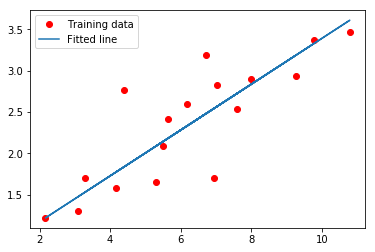

In [4]:
# -*- coding=utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# 打印日志的步长
log_step = 50
# ================ 1.定义超参数 ================
# 学习率
learning_rate = 0.01
# 最大训练步数
max_train_steps = 1000
# ================ 2.输入数据 ================
# 构造训练数据
train_X = np.array([[3.3],[4.4],[5.5],[6.71],[6.93],[4.168],[9.779],[6.182],[7.59],[2.167],[7.042],[10.791],[5.313],[7.997],[5.654],[9.27],[3.1]], dtype=np.float32)
train_Y = np.array([[1.7],[2.76],[2.09],[3.19],[1.694],[1.573],[3.366],[2.596],[2.53],[1.221],[2.827],[3.465],[1.65],[2.904],[2.42],[2.94],[1.3]], dtype=np.float32)
total_samples = train_X.shape[0]
# ================ 3.构建模型 ================
# 输入数据
X = tf.placeholder(tf.float32, [None, 1])
# 模型参数
W = tf.Variable(tf.random_normal([1, 1]), name="weight")
b = tf.Variable(tf.zeros([1]), name="bias")
# 推理值
Y = tf.matmul(X, W) + b
# ================ 4.定义损失函数 ================
# 实际值
Y_ = tf.placeholder(tf.float32, [None, 1])
# 均方差
loss = tf.reduce_sum(tf.pow(Y-Y_, 2))/(2*total_samples)
# ================ 5.创建优化器 ================
# 随机梯度下降优化器
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
# ================ 6.定义单步训练操作 ================
# 最小化损失值
train_op = optimizer.minimize(loss)
# ================ 7.创建会话 ================
with tf.Session() as sess:
    # 初始化全局变量
    sess.run(tf.global_variables_initializer()) 
# ================ 8.迭代训练 ================
    print("Start training:")
    for step in range(max_train_steps):
        sess.run(train_op, feed_dict={X: train_X, Y_: train_Y})
        # 每隔log_step步打印一次日志
        if step % log_step == 0:
            c = sess.run(loss, feed_dict={X: train_X, Y_:train_Y})
            print("Step:%d, loss==%.4f, W==%.4f, b==%.4f" % 
                    (step, c, sess.run(W), sess.run(b)))
    # 计算训练完毕的模型在训练集上的损失值，作为指标输出
    final_loss = sess.run(loss, feed_dict={X: train_X, Y_: train_Y})
    # 计算训练完毕的模型参数W和b
    weight, bias = sess.run([W, b])
    print("Step:%d, loss==%.4f, W==%.4f, b==%.4f" % 
            (max_train_steps, final_loss, sess.run(W), sess.run(b)))
    print("Linear Regression Model: Y==%.4f*X+%.4f" % (weight, bias))
# ================ 模型可视化 ================
    # 初始化Matplotlib后端
    %matplotlib inline
    # 根据训练数据X和Y，添加对应的红色圆点
    plt.plot(train_X, train_Y, 'ro', label='Training data')
    # 根据模型参数和训练数据，添加蓝色（缺省色）拟合直线
    plt.plot(train_X, weight * train_X + bias, label='Fitted line')
    # 添加图例说明
    plt.legend()
    # 画出上面定义的图案
    plt.show()

下面的线性回归为唐雨迪给出

#### 线性回归2

In [4]:
import matplotlib.pyplot as plt

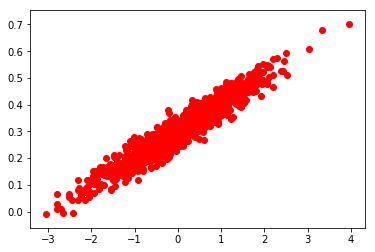

In [13]:
num_points = 1000
vectors_set = []
np.random.seed(1)
x_data = np.random.randn(1, num_points)
y_data = x_data*0.1 + 0.3 + np.random.randn(1, num_points)*0.03
# for i in range(num_points):
#     x1 = np.random.normal(0.0, 0.55)
#     y1 = x1*0.1 + 0.3 + np.random.normal(0., 0.03)
#     vectors_set.append([x1, y1])
# x_data = [v[0] for v in vectors_set]
# y_data = [v[1] for v in vectors_set]

plt.scatter(x_data, y_data, c='r')
plt.show()

In [21]:
NUM_ITER = 20

W = tf.Variable(tf.random_uniform([1], -1., 1.), name='W')
b = tf.Variable(tf.zeros([1]), name='b')

y = W*x_data + b
#损失函数和优化方法，
loss = tf.reduce_mean(tf.square(y - y_data), name='loss')
optimizer = tf.train.GradientDescentOptimizer(0.25)#学习率

train = optimizer.minimize(loss, name='train')

initer = tf.global_variables_initializer()
with tf.Session() as sess:
    #初始化
    sess.run(initer)
    print('W0:', sess.run(W))
    print('b0:', sess.run(b))
    print('loss:', sess.run(loss))
    #优化
    for step in range(NUM_ITER):
        sess.run(train)
        print('Loss:', sess.run(loss))
    #结果
    print('WL:', sess.run(W))
    print('bL:', sess.run(b))


W0: [ 0.26849747]
b0: [ 0.]
loss: 0.114655
Loss: 0.031753
Loss: 0.00933643
Loss: 0.00324538
Loss: 0.00158298
Loss: 0.00112746
Loss: 0.0010022
Loss: 0.000967651
Loss: 0.000958094
Loss: 0.000955444
Loss: 0.000954707
Loss: 0.000954502
Loss: 0.000954445
Loss: 0.000954429
Loss: 0.000954425
Loss: 0.000954424
Loss: 0.000954423
Loss: 0.000954423
Loss: 0.000954423
Loss: 0.000954423
Loss: 0.000954423
WL: [ 0.10068922]
bL: [ 0.30079246]


#### 保存

In [23]:
w = tf.Variable([
    [0.5, 1.]
])
x = tf.Variable([
    [2.],
    [1.],
])
t = tf.linspace(10., 12., 4, name='lsp')
#操作
y = tf.matmul(w, x)
init_op = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init_op)
    
    save_path = saver.save(sess, './/test_1')
    print('Saved path:', save_path)

Saved path: .//test_1


### mnist数据集

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data

In [23]:
print('Download dataset')
mnist = input_data.read_data_sets('data/', one_hot=True)

Download dataset
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tens

In [24]:
print('type of mnist:', type(mnist))
print('Size of train data:', mnist.train.num_examples)
print('Size of test data:', mnist.test.num_examples)

type of mnist: <class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Size of train data: 55000
Size of test data: 10000


In [25]:
trainimg = mnist.train.images
trainlabel = mnist.train.labels
testimg = mnist.test.images
testlabel = mnist.test.labels

### 逻辑回归器

In [32]:
temp = np.random.randn(3, 4)
print(temp)

[[ 0.71608009 -0.00266728 -0.57348279  1.23325354]
 [-2.57076883  1.80841393 -0.33048872  0.21376287]
 [ 1.2742082   0.24959993 -0.35908264  2.4381442 ]]


In [39]:
sess = tf.InteractiveSession()
print('rank:', tf.rank(temp).eval())
print('shape:', tf.shape(temp).eval())
print('argmax:', tf.argmax(temp, axis=0).eval())#最大值索引，axis=0-->最后一维


rank: 2
shape: [3 4]
argmax: [2 1 1 2]


In [57]:
LEARNING_RATE = 0.08
TRAINING_EPOCHS = 500
BATCH_SIZE = 100
DISPLAY_STEP = 5

In [53]:
x = tf.placeholder('float', [None, 784])#第一维度无穷，第二维度732
y = tf.placeholder('float', [None, 10])
W = tf.Variable(tf.random_normal([784, 10]), name='W')
b = tf.Variable(tf.zeros([10]), name='b')

actv = tf.nn.softmax(tf.matmul(x, W) + b)
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(actv), reduction_indices=1))
optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
train = optimizer.minimize(cost, name='train')

In [54]:
#预测
pred = tf.equal(tf.argmax(actv, 1), tf.argmax(y, 1))
#评估标准
accr = tf.reduce_mean(tf.cast(pred, 'float'))#cast:将bool转换为float类型

In [ ]:
init = tf.global_variables_initializer()

num_batchs = int(mnist.train.num_examples/BATCH_SIZE)
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(TRAINING_EPOCHS):
        aver_cost = 0
        for i in range(num_batchs):
            batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)
            foods = {x:batch_xs, y:batch_ys}
            sess.run(train, feed_dict=foods)
            aver_cost += sess.run(cost, feed_dict=foods)
        if epoch%DISPLAY_STEP == 0:
            foods_test = {x:mnist.test.images, y:mnist.test.labels}
            test_acc = sess.run(accr, feed_dict=foods_test)
            print('Epoch:{} \t accuracy:{}'.format(epoch+1, test_acc))
    print('Done')